In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!unzip RockPaper.zip

In [ ]:
train_dir =  '/content/train'
test_dir = '/content/test'
valid_dir = '/content/valid'

In [ ]:
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Will train model on {DEVICE}")

In [ ]:
from torchvision import datasets, transforms
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root = train_dir,
                                 transform=image_transforms,
                                 target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=image_transforms)

valid_data = datasets.ImageFolder(root = valid_dir,
                                  transform=image_transforms)

print(f"Train Data:\n{train_data}\nTest data:\n{test_data}")

In [ ]:
LABELS = ['Paper','Rock','Scissors']
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
data_iter = iter(train_loader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

plt.figure(figsize = (20,6))
for i in range(64):
  plt.subplot(4, 16, i+1)
  image = sample_images[i]
  label_text = LABELS[sample_labels[i]]
  image = image.permute((1,2,0))
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(label_text)
  plt.axis('off')
plt.suptitle("Sample Images from Test dataset")
plt.show()
plt.close()

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 224, 224, 3, 3
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE = 100, 64, 1e-2

In [ ]:
class RPSModule(nn.Module):
  def __init__(self):
    super(RPSModule, self).__init__()
    self.net = net = nn.Sequential(
        nn.Conv2d(NUM_CHANNELS, 32, kernel_size = 5, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Conv2d(32,64,kernel_size=5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Conv2d(64,64, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Flatten(),
        nn.Dropout(0.4),

        nn.Linear(64*26*26, 512),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(512, 3)
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(means, stds),
    transforms.RandomAffine(0, shear=0.2),
    transforms.RandomAffine(0, scale=(0.8,1.2)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop((IMAGE_HEIGHT< IMAGE_WIDTH)),
])

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(means, std)
])

In [ ]:
X_train = train_data
y_train = [label for _, label in train_data.imgs]

y_train = torch.tensor(y_train)

print(f"X_train shape: {len(X_train)}")
print(f"y_train shape: {y_train.shape}")

X_train shape: 2520
y_train shape: torch.Size([2520])


In [ ]:
X_val = valid_data
y_val = [label for _, label in valid_data.imgs]

y_val = torch.tensor(y_val)

print(f"X_val shape: {len(X_val)}")
print(f"y_val shape: {y_val.shape}")

X_val shape: 372
y_val shape: torch.Size([372])


In [ ]:
X_test = test_data
y_test = [label for _, label in test_data.imgs]

y_test = torch.tensor(y_test)

print(f"X_val shape: {len(X_test)}")
print(f"y_val shape: {y_test.shape}")

X_val shape: 33
y_val shape: torch.Size([33])


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

In [ ]:
train_dataset = RPSDataset(X_train, y_train, train_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7de7eabbe230>, <torch.utils.data.dataloader.DataLoader object at 0x7de7eabbfb80>)
Length of train dataloader: 79 batches of 32
Length of test dataloader: 2 batches of 32


images.shape: (32, 3, 224, 224) - labels.shape: (32,)


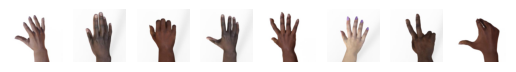

In [ ]:
data_iter = iter(train_dataloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image) # image.squeeze())
    plt.axis('off')
    if i > 6:
        break
plt.show()
plt.close()

images.shape: (32, 3, 224, 224) - labels.shape: (32,)


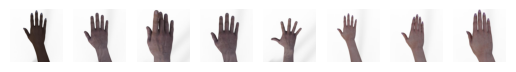

In [ ]:
data_iter = iter(test_dataloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image)
    plt.axis('off')
    if i > 6:
        break
plt.show()
plt.close()

In [ ]:
pip install torchmetrics


In [ ]:
!pip install pytorch_training_toolkit

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

# Define your metrics
metrics_map = {
    "acc": MulticlassAccuracy(num_classes=NUM_CLASSES),
    "f1": MulticlassF1Score(num_classes=NUM_CLASSES)
}

# Define your loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define your trainer function
def train(model, optimizer, train_loader, loss_fn, metrics_map, device):
    RPSModule().train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        model = RPSModule().to(DEVICE)
        optimizer.zero_grad()
        outputs = RPSModule()(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        for metric in metrics_map.values():
            metric(outputs, labels)

# Initialize your model, optimizer, and dataset loaders
# Assuming you have already defined your model, optimizer, and dataset loaders
optimizer = optim.Adam(RPSModule().parameters(), lr=LEARNING_RATE)
# Example of using the trainer function
for epoch in range(NUM_EPOCHS):
    train(RPSModule, optimizer, train_loader, loss_fn, metrics_map, DEVICE)

    # Calculate and print metrics at the end of each epoch
    for metric_name, metric in metrics_map.items():
        print(f"Epoch {epoch + 1}, {metric_name}: {metric.compute().item()}")


Epoch 1, acc: 0.34365078806877136
Epoch 1, f1: 0.342676043510437
Epoch 2, acc: 0.3363095223903656
Epoch 2, f1: 0.3354533910751343
Epoch 3, acc: 0.33201056718826294
Epoch 3, f1: 0.33130359649658203
Epoch 4, acc: 0.3308531641960144
Epoch 4, f1: 0.33067575097084045
Epoch 5, acc: 0.33277779817581177
Epoch 5, f1: 0.3325137495994568
Epoch 6, acc: 0.33101850748062134
Epoch 6, f1: 0.33094561100006104
Epoch 7, acc: 0.3323695957660675
Epoch 7, f1: 0.33226028084754944
Epoch 8, acc: 0.33343255519866943
Epoch 8, f1: 0.33330658078193665
Epoch 9, acc: 0.3343915343284607
Epoch 9, f1: 0.3342837989330292


In [ ]:
model = RPSModule().to(DEVICE)